In [1]:
%load_ext tensorboard

In [2]:
#modules
import tensorflow as tf
from tensorflow import keras
from keras import layers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm.notebook import tqdm

from sklearn.preprocessing import MinMaxScaler

import haha

In [23]:
#load dataset
df=pd.read_csv("../../Data/Harian/Rata Harian.csv").iloc[:,2]

#get data from 15 latest months
df=df[len(df)-(30*15):]

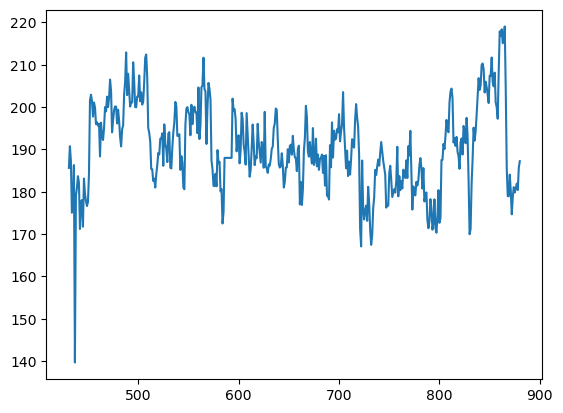

In [24]:
plt.plot(df)

In [25]:
#Rescale the data to the range of 0-to-1
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df.values.reshape(-1,1))

In [26]:
#train test split; train 12 months, 3 months for testing
train=df[:30*12]; test=df[30*12:]

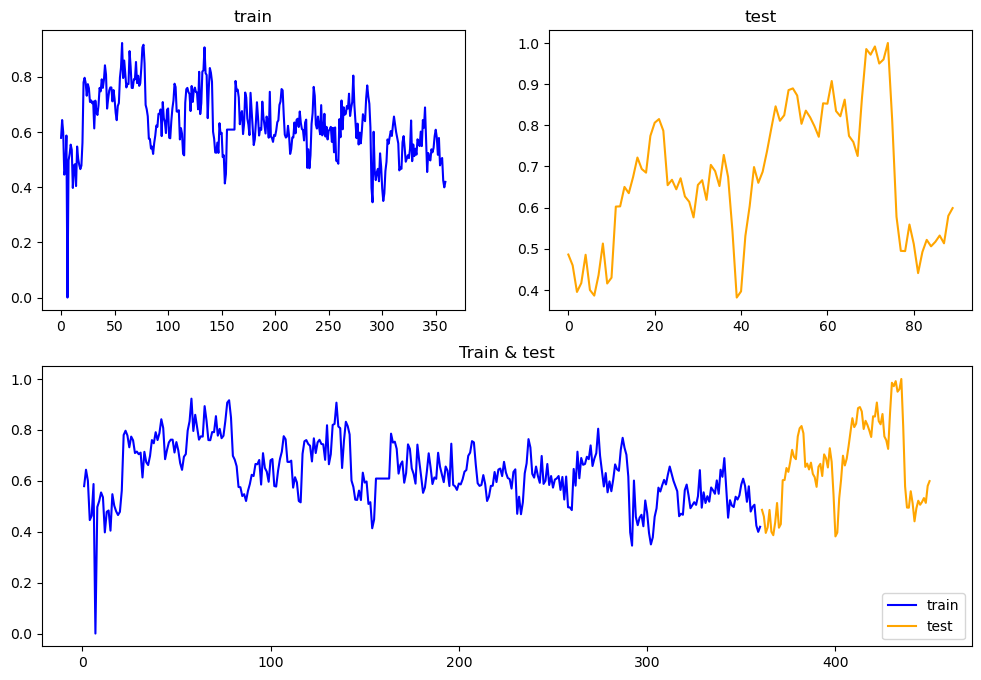

In [27]:
#plotting train, test and both
haha.plottraintest(train, test)

In [28]:
# reshape into X=t and Y=t+1
t=1
trainX, trainY = haha.lag(train)
testX, testY = haha.lag(test)

In [29]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1],1))
testX = np.reshape(testX, (testX.shape[0],  testX.shape[1],1))

In [30]:
#create model
def getmodel_compile():
    model=keras.Sequential([
        keras.layers.LSTM(4, input_shape=(t, 1)),           #4 hidden layer will be great for test, i guess?
        keras.layers.Dense(1)])                             #regression
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [31]:
model=getmodel_compile()
model.fit(trainX, trainY, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
12/12 [==============================] - 2s 5ms/step - loss: 0.4144
Epoch 2/100
12/12 [==============================] - 0s 5ms/step - loss: 0.3878
Epoch 3/100
12/12 [==============================] - 0s 5ms/step - loss: 0.3625
Epoch 4/100
12/12 [==============================] - 0s 5ms/step - loss: 0.3387
Epoch 5/100
12/12 [==============================] - 0s 5ms/step - loss: 0.3157
Epoch 6/100
12/12 [==============================] - 0s 5ms/step - loss: 0.2935
Epoch 7/100
12/12 [==============================] - 0s 6ms/step - loss: 0.2719
Epoch 8/100
12/12 [==============================] - 0s 6ms/step - loss: 0.2509
Epoch 9/100
12/12 [==============================] - 0s 11ms/step - loss: 0.2303
Epoch 10/100
12/12 [==============================] - 0s 8ms/step - loss: 0.2102
Epoch 11/100
12/12 [==============================] - 0s 8ms/step - loss: 0.1905
Epoch 12/100
12/12 [==============================] - 0s 6ms/step - loss: 0.1716
Epoch 13/100
12/12 [================

In [32]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

3/3 [==============================] - 0s 4ms/step


In [33]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

df=scaler.inverse_transform(df)
testY = scaler.inverse_transform([testY])
trainY = scaler.inverse_transform([trainY])

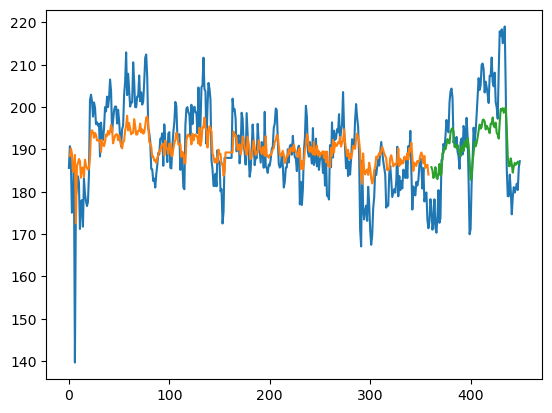

In [59]:
haha.plot_predicted(df, trainPredict, testPredict, t)

In [57]:
from sklearn.metrics import mean_squared_error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 6.94 RMSE
Test Score: 9.29 RMSE
